<a href="https://colab.research.google.com/github/FernandoJungLau/PyTorch-Study/blob/main/PyTorch_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created while following PyTorch documentation and Daniel Bourke's PyTorch course.
<br>
source materials:  
https://learnpytorch.io<br>
https://docs.pytorch.org/docs/stable/index.html<br>
https://youtu.be/Z_ikDlimN6A?si=64iIEmE2UiIbqjKw

# PyTorch Docs - Quickstart

## Setup

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.23MB/s]


We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


## Creating Models

To define a neural network in PyTorch, we create a class that inherits from **nn.Module**. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the accelerator such as CUDA, MPS, MTIA, or XPU. If the current **accelerator** is available, we will use it. Otherwise, we use the CPU.

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Optimizing the Model Parameters

In [ ]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


Training loop with predictions in the training dataset and backpropagation to adjust the model’s parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Checking the model’s performance against the test dataset to ensure it is learning.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model’s `accuracy` and `loss` at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303888  [   64/60000]
loss: 2.286021  [ 6464/60000]
loss: 2.266347  [12864/60000]
loss: 2.265998  [19264/60000]
loss: 2.241197  [25664/60000]
loss: 2.210743  [32064/60000]
loss: 2.223500  [38464/60000]
loss: 2.180671  [44864/60000]
loss: 2.171514  [51264/60000]
loss: 2.146654  [57664/60000]
Test Error: 
 Accuracy: 44.7%, Avg loss: 2.139349 

Epoch 2
-------------------------------
loss: 2.146621  [   64/60000]
loss: 2.132837  [ 6464/60000]
loss: 2.071890  [12864/60000]
loss: 2.096262  [19264/60000]
loss: 2.019951  [25664/60000]
loss: 1.965499  [32064/60000]
loss: 2.001622  [38464/60000]
loss: 1.909685  [44864/60000]
loss: 1.914742  [51264/60000]
loss: 1.838361  [57664/60000]
Test Error: 
 Accuracy: 57.1%, Avg loss: 1.840133 

Epoch 3
-------------------------------
loss: 1.880162  [   64/60000]
loss: 1.841166  [ 6464/60000]
loss: 1.722552  [12864/60000]
loss: 1.770128  [19264/60000]
loss: 1.638416  [25664/60000]
loss: 1.604070  [32064/600

## Saving Models

In [ ]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Loading Models

In [ ]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

Making predictions...

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


# PyTorch Fundamentals

In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

2.8.0+cu126


## Tensors

Creating tensors

In [ ]:
scalar = torch.tensor(7)
scalar

tensor(7)

In [ ]:
scalar.ndim

0

In [ ]:
# Tensor as Python int
scalar.item()

7

In [ ]:
# Vector
vector = torch.tensor([7, 7])
vector

tensor([7, 7])

In [ ]:
vector.ndim

1

In [ ]:
vector.shape

torch.Size([2])

In [ ]:
# MATRIX
MATRIX = torch.tensor([[7, 8],
                       [9, 10]])
MATRIX

tensor([[ 7,  8],
        [ 9, 10]])

In [ ]:
MATRIX.ndim

2

In [ ]:
MATRIX[1]

tensor([ 9, 10])

In [ ]:
MATRIX.shape

torch.Size([2, 2])

In [ ]:
# Tensor
TENSOR = torch.tensor([[[1, 2, 3],
                        [3, 6, 9],
                        [2, 4, 5]]])
TENSOR

tensor([[[1, 2, 3],
         [3, 6, 9],
         [2, 4, 5]]])

In [ ]:
TENSOR.ndim

3

In [ ]:
TENSOR.shape

torch.Size([1, 3, 3])

In [ ]:
TENSOR[0]

tensor([[1, 2, 3],
        [3, 6, 9],
        [2, 4, 5]])

## Random tensors

Neural networks start with tensors full of random numbers and then adjust those random numbers to better represent the data.

In [ ]:
# Random tensor of size (3, 4)
random_tensor = torch.rand(3, 4)
random_tensor

tensor([[0.9660, 0.7701, 0.1496, 0.9633],
        [0.3812, 0.3887, 0.4191, 0.3924],
        [0.7652, 0.1830, 0.9913, 0.5161]])

In [ ]:
random_tensor.ndim

2

In [ ]:
# Random tensor with similar shape to an image tensor
# 3 is the amount of color channels
# Color channels can come both at the start or the end
random_image_size_tensor = torch.rand(size=(224 ,224 ,3 ))
random_image_size_tensor.shape, random_image_size_tensor.ndim

(torch.Size([224, 224, 3]), 3)

## Zeros and ones

In [ ]:
# Create a tensor of all zeros
zeros = torch.zeros((3, 4))
zeros

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [ ]:
# Multiply your targe tensor by the zeros tensor to make the model ignore the values
zeros*random_tensor

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [ ]:
# Tensor of all ones
ones = torch.ones((3, 4))
ones

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

In [ ]:
ones.dtype

torch.float32

In [ ]:
random_tensor.dtype

torch.float32

## Range of tensors and tensors-like

In [ ]:
# Use torch.arange() instead of torch.range() -> this one is deprecated
# Default step is 1
torch.arange(start=0, end=1000, step=77)

tensor([  0,  77, 154, 231, 308, 385, 462, 539, 616, 693, 770, 847, 924])

In [ ]:
one_to_ten = torch.arange(start=1, end=11, step=1)
one_to_ten

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
# Creating tensors like
ten_zeros = torch.zeros_like(input=one_to_ten)
ten_zeros

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Tensor datatypes

In [ ]:
# Float 32 tensor
float_32_tensor = torch.tensor([3.0, 6.0, 9.0],
                               dtype=None, # What datatype is the tensor (ex.: torch.float16, torch.float32)
                               device=None, # What device is your tensor on (ex.: cuda)
                               requires_grad=False) # Whether or not to track gradients with this tensors operations
float_32_tensor

tensor([3., 6., 9.])

In [ ]:
# Converting float 32 to float 16
float_16_tensor = float_32_tensor.type(torch.float16)
float_16_tensor

tensor([3., 6., 9.], dtype=torch.float16)

In [ ]:
float_16_tensor * float_32_tensor

tensor([ 9., 36., 81.])

In [ ]:
int_32_tensor = torch.tensor([3, 6, 9], dtype=torch.int32)
int_32_tensor

tensor([3, 6, 9], dtype=torch.int32)

In [ ]:
float_32_tensor * int_32_tensor

tensor([ 9., 36., 81.])

## Getting information from tensors

How to get each tensor attribute:
- `tensor.dtype`: to get datatype from a tensor
- `tensor.shape`: to get shape from a tensor
- `tensor.device`: to get device from a tensor

In [ ]:
some_tensor = torch.rand(3, 4)
some_tensor

tensor([[0.6167, 0.1128, 0.7814, 0.0429],
        [0.8781, 0.0469, 0.4747, 0.0138],
        [0.3139, 0.3137, 0.2349, 0.9759]])

In [ ]:
print(some_tensor)
print(f"Datatype of tensor: {some_tensor.dtype}")
print(f"Shape of tensor: {some_tensor.shape}")
print(f"Device tensor is on: {some_tensor.device}")

tensor([[0.6167, 0.1128, 0.7814, 0.0429],
        [0.8781, 0.0469, 0.4747, 0.0138],
        [0.3139, 0.3137, 0.2349, 0.9759]])
Datatype of tensor: torch.float32
Shape of tensor: torch.Size([3, 4])
Device tensor is on: cpu


## Manipulating tensors (tensor operations)

- Addiction
- Subtraction
- Multiplication (element-wise)
- Division
- Matrix multiplication

In [ ]:
# Addiction
tensor = torch.tensor([1, 2, 3])
tensor + 100

tensor([101, 102, 103])

In [ ]:
# Multiplication
tensor * 10

tensor([10, 20, 30])

In [ ]:
# Subtraction
tensor - 10

tensor([-9, -8, -7])

In [ ]:
# PyTorch in-built functions
torch.mul(tensor, 10)

tensor([10, 20, 30])

In [ ]:
torch.add(tensor, 10)

tensor([11, 12, 13])

## Matrix multiplication

In [ ]:
# Element wise
print(tensor, "*", tensor)
print(f"Equals: {tensor * tensor}")

tensor([1, 2, 3]) * tensor([1, 2, 3])
Equals: tensor([1, 4, 9])


In [ ]:
# Matrix multiplication (dot product)
# It's faster than manually multiplying
torch.matmul(tensor, tensor)

tensor(14)

In [ ]:
%%time
value = 0
for i in range(len(tensor)):
  value += tensor[i] * tensor[i]
print(value)

tensor(14)
CPU times: user 1.52 ms, sys: 0 ns, total: 1.52 ms
Wall time: 1.98 ms


In [ ]:
%%time
torch.matmul(tensor, tensor)

CPU times: user 278 µs, sys: 9 µs, total: 287 µs
Wall time: 230 µs


tensor(14)

## Shape errors

1.  The inner dimensions must match:
* `(3, 2) @ (3, 2)` won't work
* `(2, 3) @ (3, 2)` will work
* `(3, 2) @ (2, 3)` will work
 __ __
**OBS:** The resulting matrix has the shape of the outer dimensions !
* `(2, 3) @ (3, 2)` -> `(2, 2)`
* `(3, 2) @ (2, 3)` -> `(3, 3)`

In [ ]:
# Won't work
torch.matmul(torch.rand(3, 2), torch.rand(3, 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)

In [ ]:
# Will work
torch.matmul(torch.rand(2, 3), torch.rand(3, 2))

tensor([[1.1536, 0.9779],
        [1.4037, 0.8051]])

In [ ]:
# Results in a 3x3 matrix
torch.matmul(torch.rand(3, 2), torch.rand(2, 3))

tensor([[0.5401, 0.5637, 0.7234],
        [0.7801, 0.5598, 1.0120],
        [0.5325, 0.3659, 0.6887]])

In [ ]:
# Shapes for matrix multiplication
tensor_A = torch.tensor([[1, 2],
                         [3, 4],
                         [5, 6]])

tensor_B = torch.tensor([[7, 10],
                         [8, 11],
                         [9, 12]])
torch.mm(tensor_A, tensor_B) # alias for matmul

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)

In [ ]:
tensor_A.shape, tensor_B.shape

(torch.Size([3, 2]), torch.Size([3, 2]))

We can fix this issue by manipulating the shape of one of our tensors using a **transporse**

In [ ]:
tensor_B.T, tensor_B.T.shape

(tensor([[ 7,  8,  9],
         [10, 11, 12]]),
 torch.Size([2, 3]))

In [ ]:
# Now it will work
torch.matmul(tensor_A, tensor_B.T)

tensor([[ 27,  30,  33],
        [ 61,  68,  75],
        [ 95, 106, 117]])

## Finding the min, mean, sum, etc (tensor aggregation)

In [ ]:
x = torch.arange(1, 100, 10)
x

tensor([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [ ]:
torch.max(x), x.max()

(tensor(91), tensor(91))

In [ ]:
torch.mean(x.type(torch.float32))

tensor(46.)

In [ ]:
torch.sum(x)

tensor(460)

## Positional min and max

In [ ]:
x.argmin()

tensor(0)

In [ ]:
x[0]

tensor(1)

In [ ]:
x.argmax()

tensor(9)

In [ ]:
x[9]

tensor(91)

## Reshaping, stacking, squeezing and unsqueezing tensors

* Reshaping - reshapes an input tensor to a defined shape
* View - return a view of an input tensor of certain shape but keep the same memory as the original tensor
* Stacking - combine multiple tensors on top of each other (vstack) or side by side (hstack)
* Squeeze - remove all `1` dimensions from a tensor
* Unsqueeze - add `1` dimension to a target tensor
* Permute - return a view of the input with dimensions permuted (swapped) in a certain way

In [ ]:
x = torch.arange(1., 11.)
x, x.shape

(tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), torch.Size([10]))

In [ ]:
# Add an extra dimension
x_reshaped = x.reshape(10, 1)
x_reshaped, x_reshaped.shape

(tensor([[ 5.],
         [ 2.],
         [ 3.],
         [ 4.],
         [ 5.],
         [ 6.],
         [ 7.],
         [ 8.],
         [ 9.],
         [10.]]),
 torch.Size([10, 1]))

In [ ]:
# Changing the view
z = x.view(1, 10)
z, z.shape

(tensor([[ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]),
 torch.Size([1, 10]))

Changing z changes x, because a view of a tensor shares the same memory as the original

In [ ]:
z[:, 0] = 5
z, x

(tensor([[ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]),
 tensor([ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [ ]:
# Stack tensors on top of each other
x_stacked = torch.stack([x, x, x, x], dim=0)
x_stacked

tensor([[ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]])

In [ ]:
x_reshaped.squeeze()

tensor([ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [ ]:
# Shape before squeezing
x_reshaped.shape

torch.Size([10, 1])

In [ ]:
# Shape after squeezing
x_reshaped.squeeze().shape

torch.Size([10])

In [ ]:
# Unsqueeze
x_squeezed = x_reshaped.squeeze()

x_unsqueezed = x_squeezed.unsqueeze(dim=0)
x_unsqueezed, x_unsqueezed.shape

(tensor([[ 5.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]),
 torch.Size([1, 10]))

In [ ]:
# Permute
x_original = torch.rand(size=(224, 224, 3)) # image of height: 224, width: 224 and 3 color channels

# Permute the original tensor to rearrange the axis (or dim) order
x_permuted = x_original.permute(2, 0, 1) # shifts axis 0 to 1, 1 to 2 and 2 to 0

print(f"Previous shape: {x_original.shape}")
print(f"New shape: {x_permuted.shape}")

Previous shape: torch.Size([224, 224, 3])
New shape: torch.Size([3, 224, 224])


## Indexing

In [ ]:
x = torch.arange(1, 10).reshape(1, 3, 3)
x

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [ ]:
x[0]

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
x[0][0]

tensor([1, 2, 3])

In [ ]:
x[0][0][0]

tensor(1)

In [ ]:
# ':' can select all of a target dimension
x[:, 0]

tensor([[1, 2, 3]])

In [ ]:
x[0, 0, :]

tensor([1, 2, 3])

In [ ]:
x[:, 1, 1]

tensor([5])

In [ ]:
x[0, :, 0]

tensor([1, 4, 7])

## PyTorch tensors and NumPy

PyTorch has functionality to interact with Numpy.  
NumPy is a Python numerical computing library.

In [ ]:
# NumPy array to tensor
# NumPy's default datatype is float64
array = np.arange(1.0, 8.0)
tensor = torch.from_numpy(array).type(torch.float32) # You can change the type to float32
array, tensor, tensor.dtype

(array([1., 2., 3., 4., 5., 6., 7.]),
 tensor([1., 2., 3., 4., 5., 6., 7.]),
 torch.float32)

In [ ]:
# The array has a different space in memory that of the tensor
array = array + 1
array, tensor

(array([3., 4., 5., 6., 7., 8., 9.]), tensor([1., 2., 3., 4., 5., 6., 7.]))

In [ ]:
# Tensor to array
# Just like with the last example, the array reflects the datatype of the tensor
tensor = torch.ones(7)
numpy_tensor = tensor.numpy()
tensor, numpy_tensor

(tensor([1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32))

In [ ]:
tensor = tensor + 1
tensor, numpy_tensor

(tensor([2., 2., 2., 2., 2., 2., 2.]),
 array([1., 1., 1., 1., 1., 1., 1.], dtype=float32))

## Reproducibility

Trying to take random out of random. <br>  
Neural networks start with random numbers, then execute tensor operations, followed by the stage of updating random numbers to try and make them better representations of the data. This process repeats continually.



To reduce the randomness in neural networks, there is a concept in PyTorch called **random seed**.

In [ ]:
random_tensor_A = torch.rand(3, 4)
random_tensor_B = torch.rand(3, 4)

print(random_tensor_A)
print(random_tensor_B)
print(random_tensor_A == random_tensor_B) # Compare every values of each tensor

tensor([[0.0093, 0.0559, 0.9600, 0.1316],
        [0.0959, 0.4369, 0.7624, 0.2867],
        [0.7448, 0.2385, 0.8769, 0.8824]])
tensor([[0.1128, 0.8313, 0.3947, 0.2769],
        [0.4555, 0.1754, 0.4359, 0.6174],
        [0.7879, 0.5627, 0.1923, 0.2928]])
tensor([[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]])


In [ ]:
# Creating random reproducible tensors

# Setting random seed
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
random_tensor_C = torch.rand(3, 4)
torch.manual_seed(RANDOM_SEED)
random_tensor_D = torch.rand(3, 4)

print(random_tensor_C)
print(random_tensor_D)
print(random_tensor_C == random_tensor_D)

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])
tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936]])
tensor([[True, True, True, True],
        [True, True, True, True],
        [True, True, True, True]])


## Putting tensors on the GPU

In [ ]:
# Create a tensor on the CPU
tensor = torch.tensor([1,2 ,3 ], device="cpu")

print(tensor, tensor.device)

tensor([1, 2, 3]) cpu


In [ ]:
# Move tensor to GPU (if available)
device = "cuda" if torch.cuda.is_available() else 'cpu'

tensor_on_gpu = tensor.to(device)
tensor_on_gpu, tensor_on_gpu.device

(tensor([1, 2, 3]), device(type='cpu'))

## Moving tensors back to the CPU

If tensor is on GPU, can't transform it to NumPy !

In [ ]:
# Set the tensor to the CPU
tensor_back_on_cpu = tensor_on_gpu.cpu().numpy()
tensor_back_on_cpu

array([1, 2, 3])

# PyTorch Workflow

In [56]:
import torch
from torch import nn
import matplotlib.pyplot as plt
torch.__version__

'2.8.0+cu126'

## Preparing and loading data

Creating data with the linear regression formula.  

In [57]:
# Create known parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets

In [58]:
train_split = int(0.8 * len(X)) # set and split are the same thing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How can we visualize our data?

In [59]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})

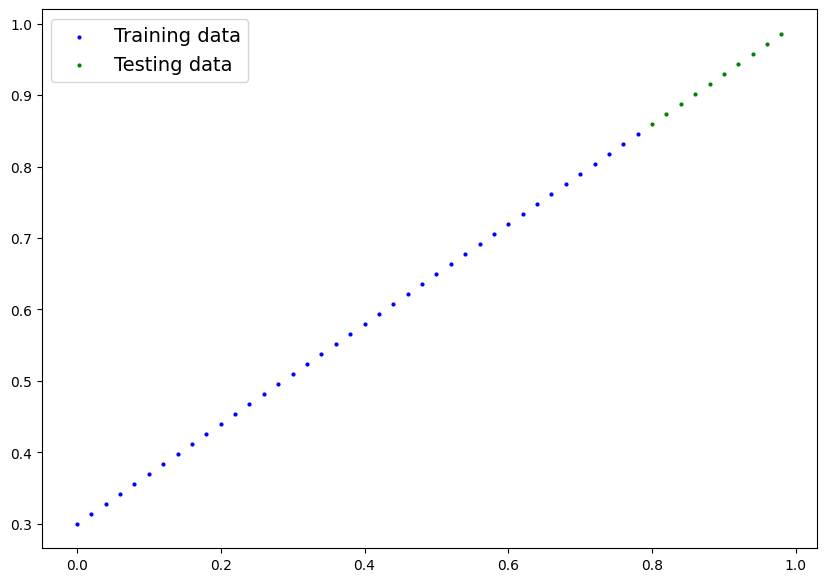

In [60]:
plot_predictions()

## Building the model

It starts with random values, look at training data and adjust the random values to better represent the ideal values.  
This is done through two main algorithms:
1. Gradient descent
2. Backpropagation

In [61]:
# Linear regression model class
class LinearRegressionModel(nn.Module): # inherits from nn.Module
  def __init__(self):
    super().__init__()

    # Initialize the model parameters
    self.weights = nn.Parameter(torch.randn(1,
        requires_grad=True,
        dtype=torch.float
    ))

    self.bias = nn.Parameter(torch.randn(1,
        requires_grad=True,
        dtype=torch.float
    ))

  # forward() defines the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # linear regression formula

### Model building essentials

* torch.nn - contains all the buildings for computational graphs
* torch.nn.Parameter - what parameters should our model try and learn, often PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network models, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our model

In [62]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [63]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [64]:
# How can we make our values closer to these?
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

In [65]:
# Inference mode disables the gradient track
# It's better than no_grad()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [66]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

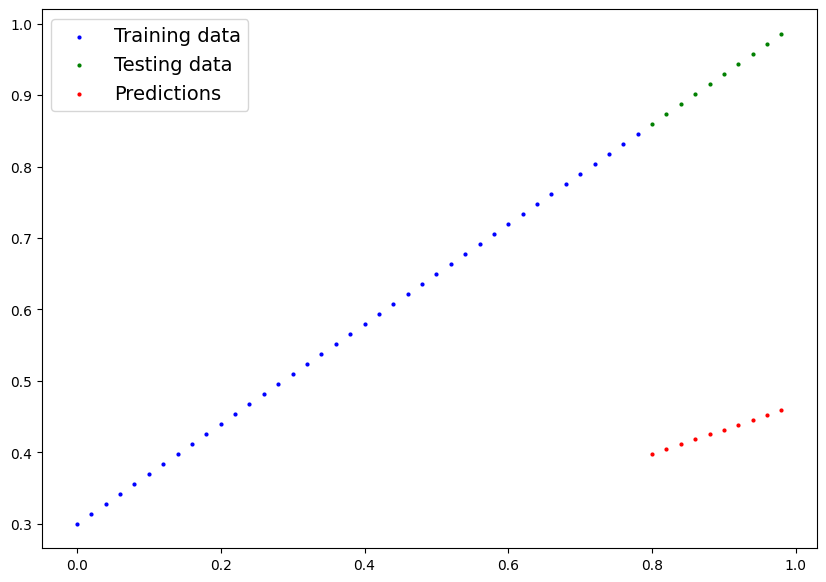

In [67]:
plot_predictions(predictions=y_preds)

## Train model

The idea of training is for a model to move from some unknown parameters to some known parameters.  
So, it changes from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function.

Things we need to train:

- **Loss function:** a funcion to measure how wrong your models's predictions are to the ideal outputs, lower is better.
- **Optimizer:** takes into account the loss of a model and adjusts the model's parameters to improve the loss function.

And for PyTorch, we also need:
 - training loop
 - testing loop

In [68]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [69]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [70]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (ex.: stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

### Building a training loop (and a testing loop)

Steps needed in a training loop:
1. Loop through the data
2. Forward pass (this involves data moving through our model's forward functions)
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model respect to the loss
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss

In [117]:
# An epoch is one loop through the data
epochs = 100

# Loop through the data
for epoch in range(epochs):
  # Set the model to training mode -> sets all parameters that require gradients to require gradients
  model_0.train()

  # Forward pass
  y_pred = model_0(X_train)

  # Calculate the loss
  loss = loss_fn(y_pred, y_train)
  print(f"Loss: {loss}")

  # Optimizer zero grad
  optimizer.zero_grad()

  # Perform backpropagation on the loss with respect of the parameters of the model
  loss.backward()

  # Step the optimizer (gradient descent)
  optimizer.step()

  model_0.eval() # turns off gradient tracking

  # Print our model state_dict()
  print(model_0.state_dict())


Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
OrderedDict({'weights': tensor([0.6990]), 'bias': tensor([0.3093])})
Loss: 0.008932482451200485
OrderedDict({'weights': tensor([0.6951]), 'bias': tensor([0.2993])})
Loss: 0.0025885067880153656
Ordered

In [118]:
# Making new predictions
with torch.inference_mode():
  y_preds_new = model_0(X_test)

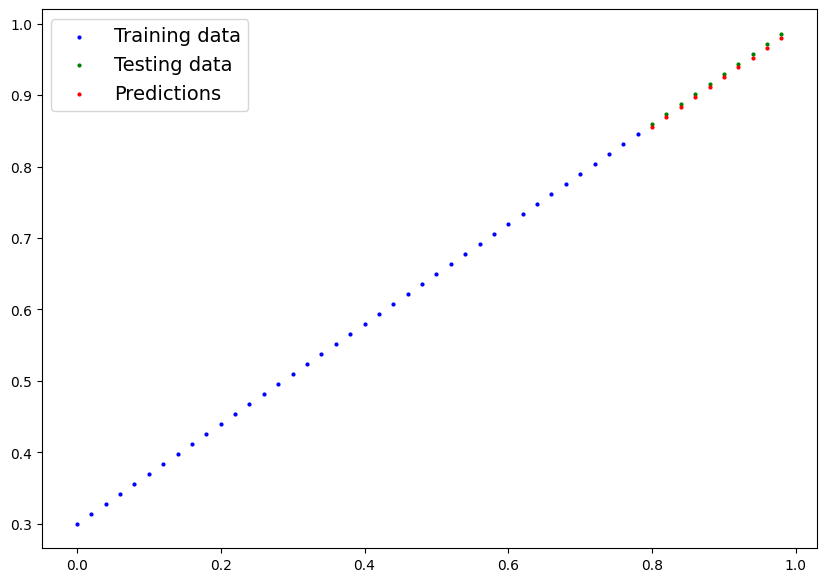

In [119]:
plot_predictions(predictions=y_preds_new)